In [ ]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/gt-big-data/solar-forecasting/sneh/analysis/2019-data/Butler_2019.csv', header = 2)
df

,Year,Month,Day,Hour,Minute,GHI,Clearsky GHI
0,2019,1,1,0,0,0,0
1,2019,1,1,0,30,0,0
2,2019,1,1,1,0,0,0
3,2019,1,1,1,30,0,0
4,2019,1,1,2,0,0,0
...,...,...,...,...,...,...,...
17515,2019,12,31,21,30,0,0
17516,2019,12,31,22,0,0,0
17517,2019,12,31,22,30,0,0
17518,2019,12,31,23,0,0,0


In [ ]:
df['Date'] = pd.to_datetime(df[['Minute','Hour','Day','Month','Year']])
df.index = range(0, df.shape[0])

# To look at only a month's worth of data
jan_df = df[df['Month'] == 1]

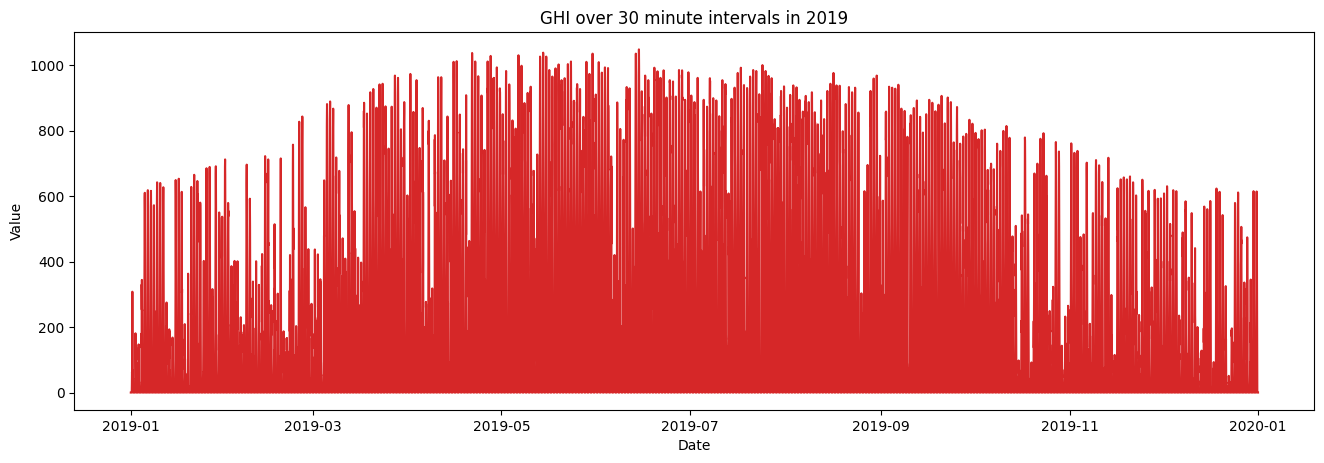

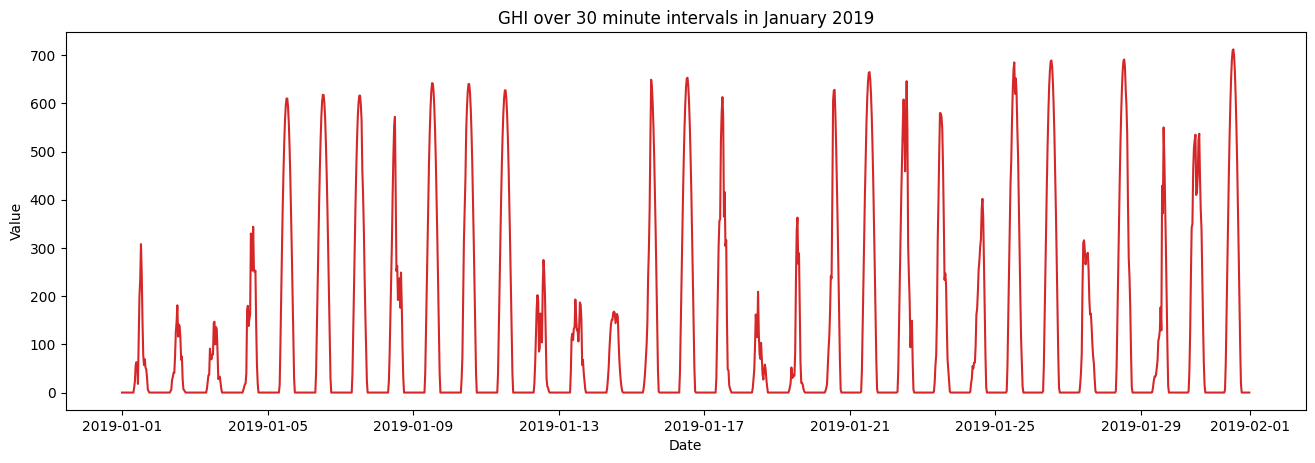

In [ ]:
import matplotlib.pyplot as plt

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    #set proportions of figure and resolution(100)
    plt.figure(figsize=(16,5), dpi=dpi)
    #plots the index against value, in this case, dates against values
    plt.plot(x, y, color='tab:red')
    #gca gets the titles
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.Date, y=df.GHI, title='GHI over 30 minute intervals in 2019') 
plot_df(jan_df, x=jan_df.Date, y=jan_df.GHI, title='GHI over 30 minute intervals in January 2019') 

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
# ADF Test
result = adfuller(df.GHI.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.413409699835616
p-value: 1.8665700986626733e-08
Critial Values:
   1%, -3.4307242638530675
Critial Values:
   5%, -2.861705410152796
Critial Values:
   10%, -2.5668580435332715


In [ ]:
from pmdarima.arima.utils import ndiffs
import pandas as pd
y = df.GHI

## Adf Test
ndiffs(y, test='adf')

# the adfuller test and ndiffs tells us that d is 0

0

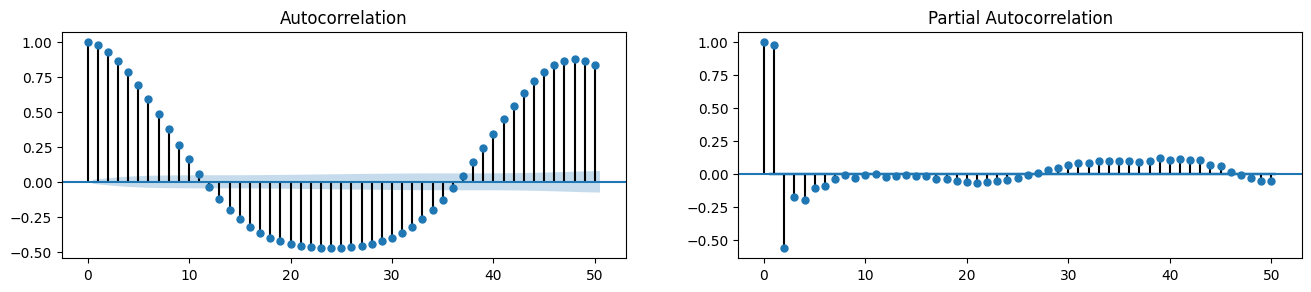

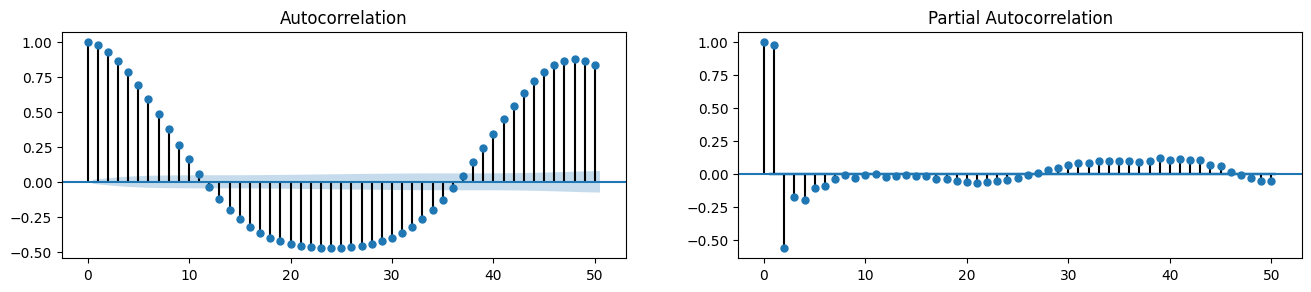

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi= 100)
plot_acf(df.GHI.tolist(), lags=50, ax=axes[0])
plot_pacf(df.GHI.tolist(), lags=50, ax=axes[1])

# pacf shows first 2 lags cross significance limit, so we know that p = 2

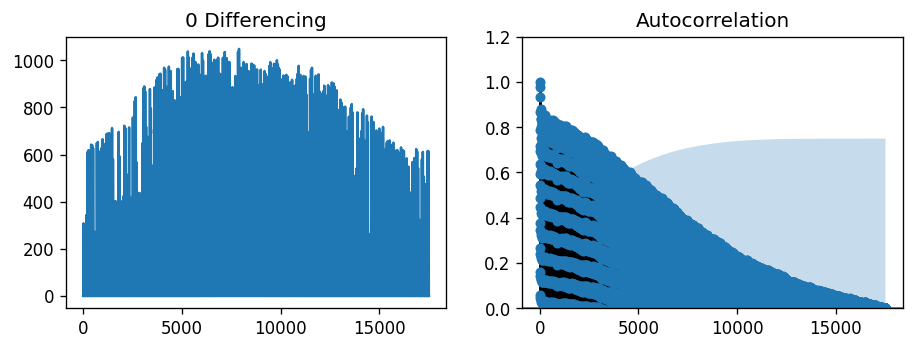

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.GHI)
axes[0].set_title('0 Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.GHI.dropna(), ax=axes[1], lags=df.GHI.shape[0] - 2)

plt.show()

# acf shows that first three values are well above significance boundary, so we know that q is 3

No handles with labels found to put in legend.


                              ARMA Model Results                              
Dep. Variable:                    GHI   No. Observations:                17520
Model:                     ARMA(2, 3)   Log Likelihood              -92534.717
Method:                       css-mle   S.D. of innovations             47.589
Date:                Wed, 18 Nov 2020   AIC                         185083.434
Time:                        22:17:42   BIC                         185137.831
Sample:                             0   HQIC                        185101.346
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        198.6852      5.124     38.774      0.000     188.642     208.728
ar.L1.GHI      1.8980      0.005    368.523      0.000       1.888       1.908
ar.L2.GHI     -0.9216      0.005   -190.964      0.0

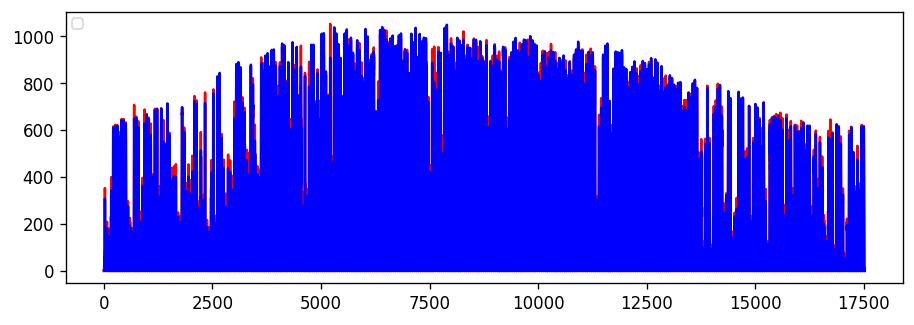

Error: 
1329.6940029976204


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

# 2,0,3 ARIMA Model
values = df.GHI.to_numpy()

model = ARIMA(df.GHI, order=(2,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())
#model_fit.plot_predict(dynamic=False)

forecasts = model_fit.predict(start = 1, end = len(values))
forecasts = forecasts.to_numpy()
forecasts[forecasts < 0] = 0
print(forecasts[20:30])
print(values[20:30])

plt.plot(forecasts, color = 'red')
plt.plot(values, color = 'blue')
plt.legend(loc='upper left', fontsize=8)

mean_actual = np.mean(values)

mse = mean_squared_error(values, forecasts)

plt.show()
print('Error: ')
print(mse)


In [ ]:
prediction_df = pd.DataFrame(forecasts, columns =['Predictions']) 
prediction_df

,Predictions
0,4.437118
1,6.936939
2,8.137771
3,9.719803
4,10.780814
...,...
17515,10.150183
17516,11.307797
17517,12.112182
17518,12.670716


In [ ]:
from google.colab import files

# To look at predictions from January 1st

df['Predictions'] = prediction_df
df[24:35]

# # Write to new csv w/ predictions
# df.to_csv('Butler_2019_wPreds.csv')
# files.download('Butler_2019_wPreds.csv')

,Year,Month,Day,Hour,Minute,GHI,Clearsky GHI,Date,Predictions
24,2019,1,1,12,0,234,542,2019-01-01 12:00:00,265.173447
25,2019,1,1,12,30,308,554,2019-01-01 12:30:00,352.980675
26,2019,1,1,13,0,247,549,2019-01-01 13:00:00,239.716926
27,2019,1,1,13,30,150,531,2019-01-01 13:30:00,128.728281
28,2019,1,1,14,0,77,497,2019-01-01 14:00:00,51.015886
29,2019,1,1,14,30,57,449,2019-01-01 14:30:00,43.697798
30,2019,1,1,15,0,69,388,2019-01-01 15:00:00,66.617242
31,2019,1,1,15,30,52,318,2019-01-01 15:30:00,43.845943
32,2019,1,1,16,0,48,239,2019-01-01 16:00:00,48.903863
33,2019,1,1,16,30,31,157,2019-01-01 16:30:00,27.752636


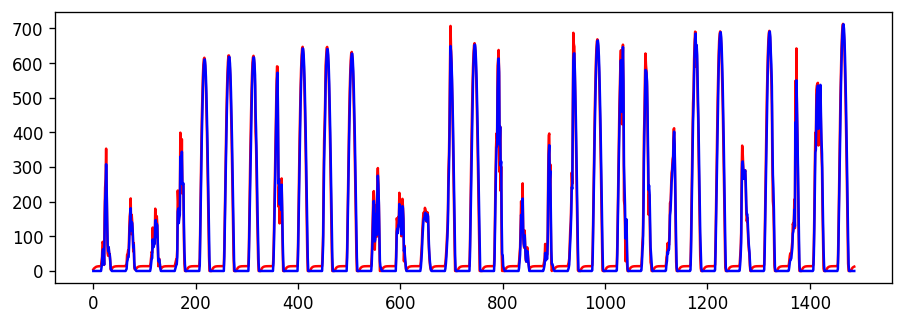

In [ ]:
jan_df = df[df['Month'] == 1]
plt.plot(jan_df.Predictions, color = 'red')
plt.plot(jan_df.GHI, color = 'blue')
plt.show()

In [ ]:
# To look at first 5 forecast predictions

length = len(df.GHI)
amt = 700
diff = length - amt
# Create Training and Test
train = df.GHI[:diff]
test = df.GHI[diff:]
print(len(train))
print(len(test))

16820
700


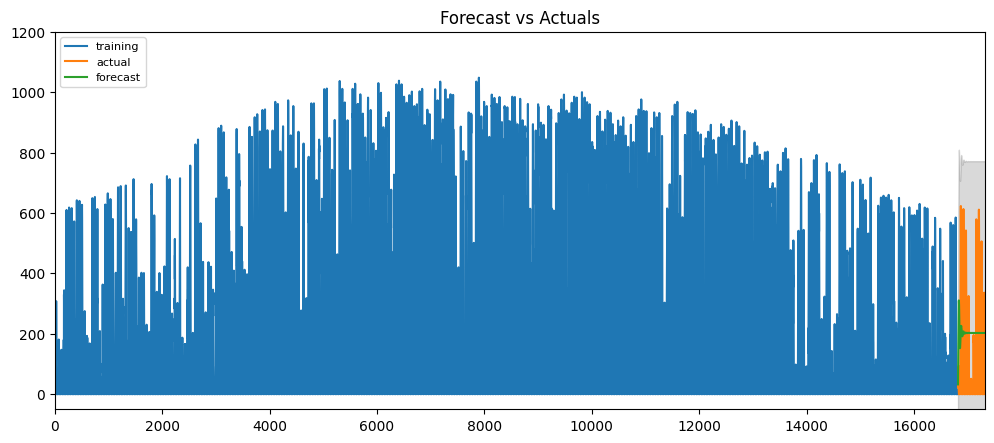

In [ ]:
# Build Model
model = ARIMA(train, order=(2, 0, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(amt, alpha=0.05)  # 95% conf
fc[fc < 0] = 0

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
fc_series = fc_series.where(fc_series > 0, 0)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.xlim(0, diff + 500)
plt.ylim(-50, 1200)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Forecast
print(fc[:10])

# Actual
print(df.GHI[diff:diff + 10].to_numpy())

[ 32.39624978  54.19895065  77.799156   102.54885882 127.81913635
 153.01280654 177.57550792 201.0050655  222.85905243 242.76050383]
[23 40 69 70 73 52 58 62 68 81]
